In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import sys
import os

# modify the path below accordingly
PATH = "/content/drive/MyDrive/HGR/gesture_face_features"

sys.path.append(os.path.join(PATH, "code"))

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# pip install mediapipe

In [12]:
pip install umap-learn

In [15]:
# importing .py files from /code
from utils import *
from cam import *
# from hand_extraction import *

In [16]:
import os
import re
import pickle

import numpy as np
# import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import requests

from PIL import Image
from io import BytesIO

import umap.umap_ as umap
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import ParameterGrid

from tensorflow.keras.models import Model

In [17]:
# Main configurations

available_letters = ["A", "H", "L", "N", "O", "P", "R"]

participants = {
  0: list(range(2914, 2951)),
  1: list(range(2871, 2904)),
  2: list(range(2323, 2356)),
  3: list(range(2285, 2314)),
  4: list(range(1646, 1675)),
  5: list(range(1503 , 1544)),
}

test_imgs = [2919, 2871, 2325, 2287, 1646, 1539]

available_models = [
  "VGG19",
  "ResNet50",
  "InceptionV3",
  "EfficientNetB0",
  "EfficientNetB1",
  "EfficientNetB6",
  #"EfficientNetB7",
]

similarity_scores = {
  ('R', 'N'): 0.8,
  ('R', 'O'): 0.6,
  ('N', 'O'): 0.6,
  ('H', 'P'): 0.8,
  ('P', 'L'): 0.8,
  ('H', 'L'): 0.6,
}
for letter in 'AHLNPRO':
  # Identical letters get maximal score
  similarity_scores[(letter, letter)] = 1.0

In [18]:
# Secondary configurations
letter = available_letters[:]
img_type = 'sign'
img_count = None
partic_num = 5
participant = participants[partic_num]

# Model configurations
model_name = available_models[2]
input_dim = (224, 224) # default
model = None
include_top = True
debug = False
random_state = 42

In [19]:
model_configs = {
  'resnet50': {
    'last_conv_layer_name': 'conv5_block3_out',
    'fc_gap_layer_name': 'avg_pool',
    'input_dim': (224, 224),
  },
  'vgg19': {
    'last_conv_layer_name': 'block5_conv4',
    'fc_gap_layer_name': 'fc2',
    'input_dim': (224, 224),
  },
  'inception_v3': {
    'last_conv_layer_name': 'mixed10',
    'fc_gap_layer_name': 'avg_pool',
    'input_dim': (299, 299),
  },
  'efficientnetb0': {
    'last_conv_layer_name': 'top_conv',
    'fc_gap_layer_name': 'avg_pool',
    'input_dim': (224, 224),
  },
  'efficientnetb1': {
    'last_conv_layer_name': 'top_conv',
    'fc_gap_layer_name': 'avg_pool',
    'input_dim': (240, 240)
  },
  'efficientnetb6': {
    'last_conv_layer_name': 'top_conv',
    'fc_gap_layer_name': 'avg_pool',
    'input_dim': (528, 528),
  },
  # 'efficientnetb7': {
  #   'last_conv_layer_name': 'top_conv',
  #   'fc_gap_layer_name': 'avg_pool',
  #   'input_dim': (600, 600),
  # }
}

In [20]:
def load_model(model_name, include_top=True, debug=False):
  if model_name == 'ResNet50':
    from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
    model = ResNet50(include_top=include_top)
    configs = model_configs['resnet50']
  elif model_name == 'VGG19':
    from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
    model = VGG19(include_top=include_top)
    configs = model_configs['vgg19']
  elif model_name == 'InceptionV3':
    from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
    model = InceptionV3(include_top=include_top)
    configs = model_configs['inception_v3']
  elif model_name == 'EfficientNetB0':
    from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input, decode_predictions
    model = EfficientNetB0(include_top=include_top)
    configs = model_configs['efficientnetb0']
  elif model_name == 'EfficientNetB1':
    from tensorflow.keras.applications.efficientnet import EfficientNetB1, preprocess_input, decode_predictions
    model = EfficientNetB1(include_top=include_top)
    configs = model_configs['efficientnetb1']
  elif model_name == 'EfficientNetB6':
    from tensorflow.keras.applications.efficientnet import EfficientNetB6, preprocess_input, decode_predictions
    model = EfficientNetB6(include_top=include_top)
    configs = model_configs['efficientnetb6']
  elif model_name == 'EfficientNetB7':
    from tensorflow.keras.applications.efficientnet import EfficientNetB7, preprocess_input, decode_predictions
    model = EfficientNetB7(include_top=include_top)
    configs = model_configs['efficientnetb7']
  else:
    raise ValueError("Unsupported model name.")

  if debug:
    print(model.summary())

  print(f"{model.name} loaded")

  layer_names = (configs['last_conv_layer_name'], configs['fc_gap_layer_name'])
  input_dim = configs['input_dim']

  output = (
    model,
    layer_names,
    input_dim,
    preprocess_input,
    decode_predictions,
  )

  return output

In [21]:
# Loading data
folder_paths, img_paths, labels, img_numbers = get_paths(os.path.join(PATH, 'samples', img_type), letter, img_count=img_count, img_numbers_list=participant)
imgs = load_imgs(img_paths)

40 images loaded


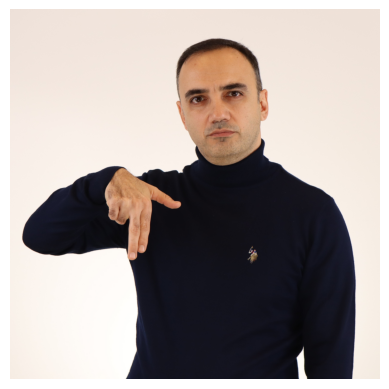

In [22]:
 # Testing
img = imgs[9]
plt.imshow(img)
plt.axis('off')
plt.show()

In [23]:
def get_features(img, model, input_dim, layer_names):
  # Applies forward pass and gets features for given layers
  feature_model = Model(inputs=model.input, outputs=[model.get_layer(name).output for name in layer_names])

  img_resized = img.resize(input_dim)
  img_array = np.array(img_resized)
  img_array = np.expand_dims(img_array, axis=0)
  img_array = preprocess_input(img_array)

  return feature_model.predict(img_array)


def get_layer_feats(model, imgs, layer_names, input_dim, partic_num, path=os.path.join(PATH, 'pickle')):
  """
  Extracts and saves features from specified layers of a model for each image in imgs.
  If a feature file for a layer already exists, it loads that layer's features directly.
  For missing layers, it performs a forward pass to compute and save those features.

  Parameters:
  - model: The model from which to extract features.
  - partic_num: Identifier for the participant (used in filenames).
  - imgs: List of images to process.
  - layer_names: List of layer names for feature extraction.
  - input_dim: Input dimensions for the model.
  - path: Base path to save or load pickle files.

  Returns:
  - all_feats: Dictionary of features, with each layer's features stored as a numpy array.
  """
  all_feats = {}
  layers_to_compute = []

  for layer in layer_names:
    feats_file = f"{model.name}_{layer}_participant_{partic_num}.pkl"
    feats_path = os.path.join(path, feats_file)

    if os.path.exists(feats_path):
      with open(feats_path, 'rb') as f:
          all_feats[layer] = pickle.load(f)
      print(f"Loaded existing features for layer '{layer}' from {feats_path}")
    else:
      layers_to_compute.append(layer)
      all_feats[layer] = []

  if layers_to_compute:
    print(f"Performing forward pass for layer(s): {layers_to_compute}")
    for i, img in enumerate(imgs):
      feature_activations = get_features(img, model, input_dim, layers_to_compute)

      for layer, feat in zip(layers_to_compute, feature_activations):
          all_feats[layer].append(feat.flatten())
      print(f"Processed image {i}.")

    for layer in layers_to_compute:
      all_feats[layer] = np.array(all_feats[layer])

      feats_file = f"{model.name}_{layer}_participant_{partic_num}.pkl"
      feats_path = os.path.join(path, feats_file)

      with open(feats_path, 'wb') as f:
          pickle.dump(all_feats[layer], f)
      print(f"Features for layer '{layer}' saved to {feats_path}")

  return all_feats

def load_partic_feats(partic_num, path=os.path.join(PATH, 'pickle')):
  # loads all model features for all layers for a single participant
  partic_feats = {}

  print(f"LOADING feature files for participant {partic_num}:\n")

  for file in os.listdir(path):
    if f"participant_{partic_num}" in file:
      for model_name in model_configs.keys():
        if model_name in file:
            feats_path = os.path.join(path, file)
            try:
              with open(feats_path, 'rb') as f:
                loaded_feats = pickle.load(f)

                if model_name not in partic_feats:
                    partic_feats[model_name] = {}

                layer_names = list(model_configs[model_name].values())[:2]
                for layer_name in layer_names:
                  if layer_name in file:
                    partic_feats[model_name][layer_name] = loaded_feats
                    print(f"Loaded {layer_name} features for {model_name}")
            except FileNotFoundError:
                print(f"File not found: {feats_path}")

  return partic_feats

In [24]:
# model, layer_names, input_dim, preprocess_input, decode_predictions = load_model("VGG19", include_top, debug)
# get_layer_feats(model, imgs, layer_names, input_dim, partic_num)

In [25]:
def get_similarity_score(letter1, letter2):
    return similarity_scores.get((letter1, letter2)) or similarity_scores.get((letter2, letter1), 0)

def calculate_similarity_scores(clustered_images):
    layer_scores = {}
    for model_name, layers in clustered_images.items():
        layer_scores[model_name] = {}
        for layer_name, clusters in layers.items():
            total_layer_score = 0
            total_pairs = 0

            for cluster_id, images in clusters.items():
                letters = [label for _, label in images]
                cluster_score = 0
                num_pairs = 0

                # Count occurrences of each letter
                letter_counts = {}
                for letter in letters:
                    if letter in letter_counts:
                        letter_counts[letter] += 1
                    else:
                        letter_counts[letter] = 1

                # Generate all possible pairs considering duplicates
                for letter1, count1 in letter_counts.items():
                    for letter2, count2 in letter_counts.items():
                        if letter1 != letter2:
                            pair_score = get_similarity_score(letter1, letter2)
                            cluster_score += pair_score * count1 * count2  # Each pair contributes to the score
                            num_pairs += count1 * count2  # Count all combinations of the pairs
                        else:
                            # Handle pairs of the same letter
                            pair_score = get_similarity_score(letter1, letter2)
                            # Calculate combinations of 'count1' taken 2 at a time: C(n, 2) = n * (n - 1) / 2
                            cluster_score += pair_score * (count1 * (count1 - 1) // 2)
                            num_pairs += count1 * (count1 - 1) // 2  # Count the combinations of the same letter

                # Calculate the average cluster score
                cluster_score = cluster_score / num_pairs if num_pairs > 0 else 0
                total_layer_score += cluster_score
                total_pairs += 1

            # Calculate the average score for the layer
            average_layer_score = total_layer_score / total_pairs if total_pairs > 0 else 0
            layer_scores[model_name][layer_name] = average_layer_score
            print(f"Average score for {model_name} layer {layer_name}: {average_layer_score:.2f}")

    return layer_scores

In [26]:
def calculate_clusters(embeddings, labels, img_numbers, n_clusters=len(set(labels)), random_state=None, verbose=True):
    """
    Calculate clusters for each model and layer's UMAP embedding using KMeans.

    Parameters:
    - embeddings: dict containing UMAP embeddings for each model and layer.
    - labels: list of ground truth labels corresponding to each image.
    - img_numbers: list of image numbers or IDs corresponding to each embedding.

    Returns:
    - clustered_images: dict of clusters, with each cluster containing tuples of (img_num, label).
    """
    clustered_images = {}
    all_clusters = {}

    for model_name in embeddings:
        all_clusters[model_name] = {}
        clustered_images[model_name] = {}

        for layer_name, embedding in embeddings[model_name].items():
            kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
            cluster_labels = kmeans.fit_predict(embedding)
            all_clusters[model_name][layer_name] = cluster_labels
            print(f"Calculated KMeans clusters for {model_name} layer {layer_name}")

            # Organize images by clusters
            clusters = {i: [] for i in range(n_clusters)}
            for img_num, cluster, label in zip(img_numbers, cluster_labels, labels):
                clusters[cluster].append((img_num, label))

            clustered_images[model_name][layer_name] = clusters

            if verbose:
              print(f"Clusters for {model_name} layer {layer_name}:")

              for cluster_id, img_list in clusters.items():
                  print(f"{cluster_id}: {img_list}")
              print()

    return all_clusters, clustered_images

In [27]:
def get_embeddings(partic_feats, labels, img_numbers, partic_num, param_grid=None, n_components=2, method="umap", path=os.path.join(PATH, 'pickle'), verbose=False, random_state=None):
    """
    Generate or load embeddings for participants' features using dimensionality reduction techniques such as UMAP or t-SNE.

    The function attempts to load pre-computed embeddings from a pickle file based on the specified participant number and random state.
    If the file does not exist, it computes embeddings using the specified dimensionality reduction method and parameters,
    finds the best embedding based on clustering performance, and saves the results for future use.

    Parameters:
    - partic_feats (dict): A nested dictionary containing features for each participant model.
      The outer keys represent model names, and the inner keys represent layer names, with corresponding feature arrays.
    - labels (list): A list of ground truth labels corresponding to each image.
    - img_numbers (list): A list of image numbers or identifiers corresponding to each feature embedding.
    - partic_num (int): An identifier for the participant, used in the file naming for saving/loading embeddings.
    - param_grid (dict, optional): A dictionary of parameter values for tuning the dimensionality reduction method.
      If not provided, default parameters will be used.
    - n_components (int, optional): The number of dimensions for the output embeddings. Defaults to 2.
    - method (str, optional): The dimensionality reduction method to use. Must be either 'umap' or 'tsne'. Defaults to 'umap'.
    - path (str, optional): The directory path where the pickle file is stored. Defaults to a predefined PATH.
    - verbose (bool, optional): If True, additional output is printed during processing. Defaults to False.
    - random_state (int, optional): Seed used by the random number generator for reproducibility. If None, randomness is not controlled.

    Returns:
    - embeddings (dict): A dictionary containing the computed best embeddings for each model and layer.
    - results_info (dict): A dictionary containing information about the parameter tuning results,
      including the best parameters and scores for each model and layer.

    Raises:
    - ValueError: If the specified method is not 'umap' or 'tsne'.
    """

    # Define the file path based on partic_num and random_state
    file_name = f"{method}_embeddings_participant_{partic_num}_rs_{random_state}.pkl"
    file_path = os.path.join(path, file_name)

    # Check if the file exists; if it does, load the data from the file
    if os.path.exists(file_path):
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
            embeddings = data['embeddings']
            results_info = data['results_info']
        print(f"Loaded embeddings and results from {file_path}.")
        return embeddings, results_info

    # Set default parameter grids for UMAP and t-SNE
    if method == "umap":
        default_params = {
            'n_neighbors': [5, 10, 15, 30, 50],
            'min_dist': [0.01, 0.05, 0.1, 0.3],
            'metric': ["euclidean", "cosine"]
        }
    elif method == "tsne":
        default_params = {
            'perplexity': [10, 15, 20, 25],
            'learning_rate': [100, 300, 600, 1000],
            'metric': ["euclidean", "cosine"]
        }
    else:
        raise ValueError("Method must be 'umap' or 'tsne'")

    # Use the provided parameter grid or the default one
    param_grid = param_grid if param_grid else default_params
    embeddings = {}
    results_info = {}

    for model_name in partic_feats:
        embeddings[model_name] = {}
        results_info[model_name] = {}

        for layer_name, features in partic_feats[model_name].items():
            best_embedding = None
            best_score = -np.inf
            best_params = None

            for params in ParameterGrid(param_grid):
                if method == "umap":
                    reducer = umap.UMAP(
                        n_neighbors=params['n_neighbors'],
                        min_dist=params['min_dist'],
                        n_components=n_components,
                        metric=params['metric'],
                        random_state=random_state
                    )
                elif method == "tsne":
                    reducer = TSNE(
                        n_components=n_components,
                        perplexity=params['perplexity'],
                        learning_rate=params['learning_rate'],
                        metric=params['metric'],
                        random_state=random_state
                    )

                embedding = reducer.fit_transform(features)
                _, clusters = calculate_clusters({model_name: {layer_name: embedding}}, labels, img_numbers, verbose=verbose, random_state=random_state)

                layer_scores = calculate_similarity_scores(clusters)
                average_layer_score = layer_scores[model_name][layer_name]

                results_info[model_name][layer_name] = results_info[model_name].get(layer_name, [])
                results_info[model_name][layer_name].append({'params': params, 'score': average_layer_score})

                if average_layer_score > best_score:
                    best_score = average_layer_score
                    best_embedding = embedding
                    best_params = params

            embeddings[model_name][layer_name] = best_embedding
            print(f"Best params for {model_name} layer {layer_name}: {best_params} with score: {best_score:.2f}")

    # Save embeddings and results_info to a pickle file
    with open(file_path, 'wb') as f:
        pickle.dump({'embeddings': embeddings, 'results_info': results_info}, f)

    return embeddings, results_info

In [28]:
def analyze_results(results_info, top_n=5):
    analysis = {}
    overall_best_score = float('-inf')  # Initialize to negative infinity
    overall_best_info = None  # To store the best score details

    for model_name, layers in results_info.items():
        analysis[model_name] = {}

        all_scores = []
        for layer_name, results in layers.items():
            all_scores.extend([(model_name, layer_name, res['params'], res['score']) for res in results])

        all_scores.sort(key=lambda x: x[3], reverse=True)  # Sort by score in descending order

        # Select the top N best layers
        analysis[model_name]['top_n_best_layers'] = all_scores[:top_n]

        if all_scores:
            top_n_scores = [layer[3] for layer in analysis[model_name]['top_n_best_layers']]
            average_top_n_score = sum(top_n_scores) / len(top_n_scores) if top_n_scores else 0
            analysis[model_name]['average_top_n_score'] = average_top_n_score

            # Identify the best model based on score
            best_model = max(all_scores, key=lambda x: x[3])  # Best model based on score
            analysis[model_name]['best_model'] = {
                'model': best_model[0],
                'layer': best_model[1],
                'params': best_model[2],
                'score': best_model[3]
            }

            # Check for overall best score
            if best_model[3] > overall_best_score:
                overall_best_score = best_model[3]
                overall_best_info = {
                    'model': best_model[0],
                    'layer': best_model[1],
                    'params': best_model[2],
                    'score': best_model[3]
                }

    # Print the analysis results
    print("\nAnalysis Results:")
    for model_name, data in analysis.items():
        print(f"\nModel: {model_name}")
        print(f"Average Score of Top {top_n} Layers: {data['average_top_n_score']:.4f}")
        print(f"Top {top_n} Best Layers:")
        for layer_info in data['top_n_best_layers']:
            print(f"  Layer: {layer_info[1]}, Score: {layer_info[3]:.2f}, Params: {layer_info[2]}")

    print(f"Best score: {overall_best_info}")

In [29]:
def plot_image_clusters(clustered_images, model_name, layer_name, target_size=(100, 100)):
    clusters = clustered_images.get(model_name, {}).get(layer_name, {})

    if not clusters:
        print(f"No clusters found for {model_name} {layer_name}.")
        return

    # Determine the maximum number of images in any cluster for consistent row widths
    max_images_per_row = max(len(img_list) for img_list in clusters.values())
    fig, axs = plt.subplots(len(clusters), max_images_per_row, figsize=(max_images_per_row * 3, len(clusters) * 3))

    for row_idx, (cluster, img_list) in enumerate(clusters.items()):
        for col_idx in range(max_images_per_row):
            if col_idx < len(img_list):
                img_num, label = img_list[col_idx]

                if img_num in img_numbers:
                    img_index = img_numbers.index(img_num)
                    img = imgs[img_index]  # Get the image from imgs list

                    # Resize the image
                    resized_img = img.resize(target_size)

                    # Plot the image
                    axs[row_idx, col_idx].imshow(resized_img)
                    axs[row_idx, col_idx].axis('off')  # Hide axes
                    axs[row_idx, col_idx].set_title(f'Letter: {label}')  # Optional title
                else:
                    print(f"Warning: img_num {img_num} is out of bounds for imgs list.")
                    axs[row_idx, col_idx].axis('off')  # Hide unused subplots
            else:
                axs[row_idx, col_idx].axis('off')  # Hide unused subplots

    # Adjust layout for the entire figure
    plt.tight_layout()
    plt.show()


In [30]:
def visualize_embedding(embedding, labels, cluster_labels, img_numbers, model_name, layer_name, n_clusters=len(set(labels))):
    """Visualizes the embedding with a title of the model and layer name."""
    unique_labels = list(set(labels))
    markers = {'A': 'o', 'H': 's', 'L': 'D', 'N': '^', 'O': 'v', 'P': '<', 'R': '>'}
    colors = plt.cm.Spectral(np.linspace(0, 1, n_clusters))

    plt.figure(figsize=(12, 10))
    plt.title(f"Embedding Visualization for {model_name} - {layer_name}")

    for letter in unique_labels:
        indices = [i for i, l in enumerate(labels) if l == letter]
        cluster_color = colors[cluster_labels[indices[0]]]
        plt.scatter(embedding[indices, 0], embedding[indices, 1],
                    color=cluster_color,
                    marker=markers.get(letter, 'o'),
                    label=letter,
                    s=80, alpha=1)

        for i in indices:
            plt.text(embedding[i, 0], embedding[i, 1], img_numbers[i], fontsize=8, ha='right', color="black")

    for cluster_idx in range(n_clusters):
        cluster_points = embedding[cluster_labels == cluster_idx]
        if cluster_points.size > 0:
            min_x, min_y = cluster_points.min(axis=0)
            max_x, max_y = cluster_points.max(axis=0)
            padding = 0.1
            plt.gca().add_patch(plt.Rectangle(
                (min_x - padding, min_y - padding),
                (max_x - min_x) + 2 * padding,
                (max_y - min_y) + 2 * padding,
                fill=False, edgecolor=colors[cluster_idx], linewidth=1.5, linestyle="--"
            ))

    plt.legend(title='Letters', loc='center left', bbox_to_anchor=(1.05, 0.5), fancybox=True, shadow=True, ncol=1)
    plt.grid(True, linestyle='--', alpha=1)
    plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout to fit the legend
    plt.show()


In [31]:
def plot_embeddings(embeddings, all_clusters, labels, img_numbers, n_clusters=len(set(labels)), model_to_plot=None, layer_to_plot=None):
    """
    Plots embeddings for each model and layer.
    Optionally filter by specific model or layer.
    """
    for model_name in embeddings:
        if model_to_plot and model_name != model_to_plot:
            continue  # Skip if not the chosen model

        for layer_name, embedding in embeddings[model_name].items():
            if layer_to_plot and layer_name != layer_to_plot:
                continue  # Skip if not the chosen layer

            cluster_labels = all_clusters[model_name][layer_name]
            visualize_embedding(
                embedding=embedding,
                labels=labels,
                cluster_labels=cluster_labels,
                img_numbers=img_numbers,
                n_clusters=n_clusters,
                model_name=model_name,
                layer_name=layer_name
            )


In [32]:
# all_partic_feats = []
# all_imgs = []
# all_embeddings = []
# all_results_info = []
# all_layer_scores = []

# for partic_num in range(6):
#   participant = participants[partic_num]
#   folder_paths, img_paths, labels, img_numbers = get_paths(os.path.join(PATH, 'samples', img_type), letter, img_count=img_count, img_numbers_list=participant)
#   all_imgs.append(load_imgs(img_paths))
#   partic_feats = load_partic_feats(partic_num)
#   all_partic_feats.append(partic_feats)
#   embeddings, results_info = get_embeddings(partic_feats, labels, img_numbers, partic_num, method="tsne", random_state=random_state, verbose=False)
#   all_embeddings.append(embeddings)
#   all_results_info.append(results_info)
#   _, clustered_images = calculate_clusters(embeddings, labels, img_numbers, random_state=random_state)
#   layer_scores = calculate_similarity_scores(clustered_images)
#   all_layer_scores.append(layer_scores)

In [33]:
# def get_top_n_scores(all_results_info, top_n):
#     top_scores_dict = {}

#     # Iterate through all participants' results
#     for partic_index, partic_results in enumerate(all_results_info):
#         partic_key = f'Participant_{partic_index}'  # Create a key for each participant
#         top_scores_dict[partic_key] = {}  # Initialize a dictionary for this participant

#         for model_name, layers_info in partic_results.items():
#             if model_name not in top_scores_dict[partic_key]:
#                 top_scores_dict[partic_key][model_name] = {}
#             for layer_name, scores_info in layers_info.items():
#                 # Collect scores from the scores_info
#                 scores = [info['score'] for info in scores_info]

#                 # Find unique top n scores for this layer
#                 unique_sorted_scores = sorted(set(scores), reverse=True)
#                 top_n_scores = unique_sorted_scores[:top_n]

#                 # Round scores to two decimal places
#                 rounded_top_n_scores = np.round(top_n_scores, 4)
#                 top_scores_dict[partic_key][model_name][layer_name] = rounded_top_n_scores.tolist()  # Convert to list for better readability

#     return top_scores_dict

# # Example usage
# top_n = 1  # Specify how many top scores you want
# top_scores = get_top_n_scores(all_results_info, top_n)

# # Print the top scores for each model layer for each participant
# print("Top Scores for Each Participant:")
# for participant, models in top_scores.items():
#     print(f"{participant}:")
#     for model, layers in models.items():
#         print(f"  {model}:")
#         for layer, scores in layers.items():
#             print(f"    {layer}: {scores}")

In [34]:
partic_feats = load_partic_feats(partic_num)
embeddings, results_info = get_embeddings(partic_feats, labels, img_numbers, partic_num, method="umap", random_state=random_state, verbose=False)
all_clusters, clustered_images = calculate_clusters(embeddings, labels, img_numbers, random_state=random_state)
layer_scores = calculate_similarity_scores(clustered_images)
analyze_results(results_info, top_n=1)

LOADING feature files for participant 5:

Loaded block5_conv4 features for vgg19
Loaded fc2 features for vgg19
Loaded conv5_block3_out features for resnet50
Loaded avg_pool features for resnet50
Loaded mixed10 features for inception_v3
Loaded avg_pool features for inception_v3
Loaded top_conv features for efficientnetb0
Loaded avg_pool features for efficientnetb0
Loaded top_conv features for efficientnetb1
Loaded avg_pool features for efficientnetb1
Loaded top_conv features for efficientnetb6
Loaded avg_pool features for efficientnetb6
Loaded embeddings and results from /content/drive/MyDrive/HGR/gesture_face_features/pickle/umap_embeddings_participant_5_rs_42.pkl.
Calculated KMeans clusters for vgg19 layer block5_conv4
Clusters for vgg19 layer block5_conv4:
0: [(1526, 'L'), (1517, 'N'), (1514, 'R'), (1516, 'R')]
1: [(1540, 'A'), (1504, 'O'), (1505, 'O'), (1506, 'O'), (1507, 'O'), (1508, 'O'), (1527, 'P'), (1529, 'P')]
2: [(1539, 'A'), (1541, 'A'), (1542, 'A'), (1543, 'A'), (1521, 'N')

In [35]:
plot_image_clusters(clustered_images, "efficientnetb1", "avg_pool")

Output hidden; open in https://colab.research.google.com to view.

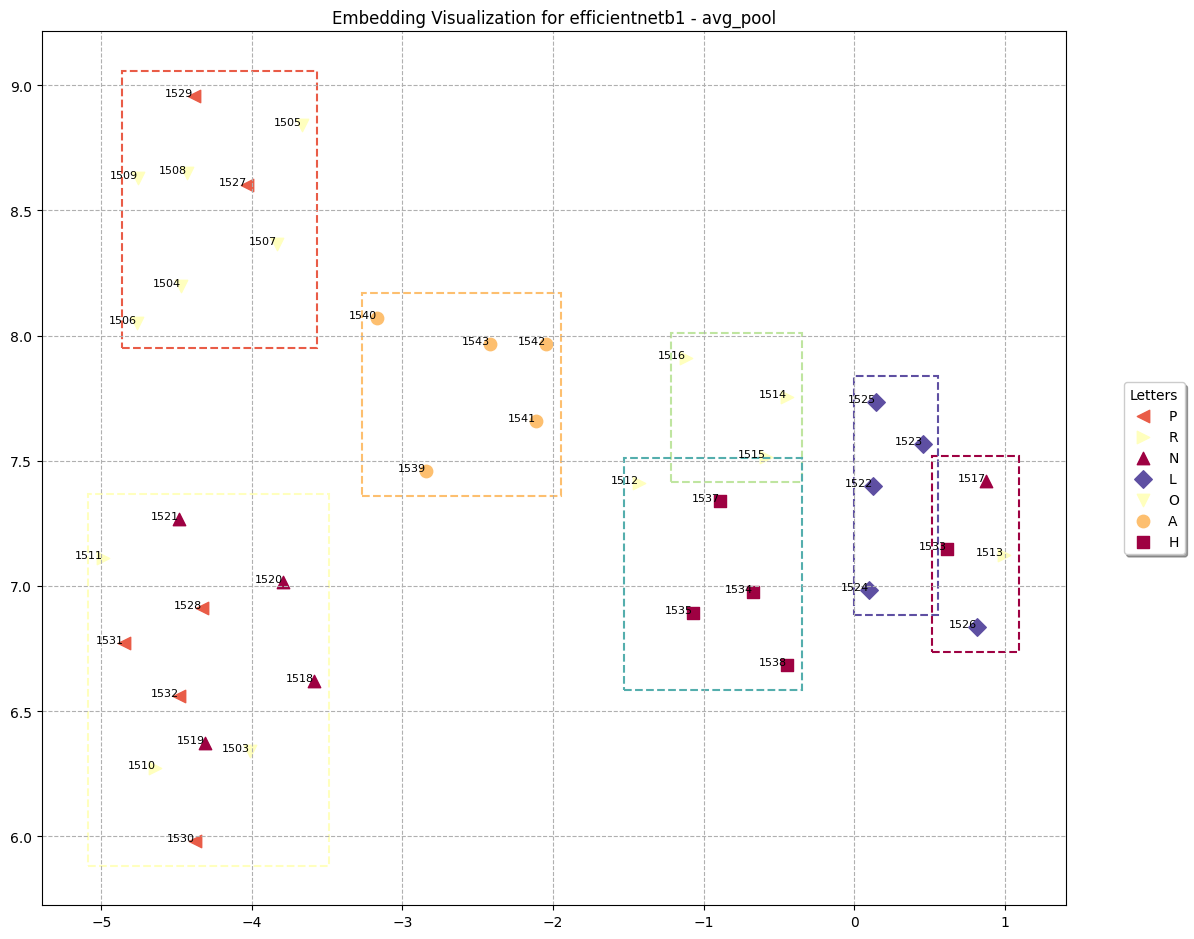

In [36]:
model_name = "efficientnetb1"
layer_name = "avg_pool"
visualize_embedding(embeddings[model_name][layer_name], labels, all_clusters[model_name][layer_name], img_numbers, model_name, layer_name)

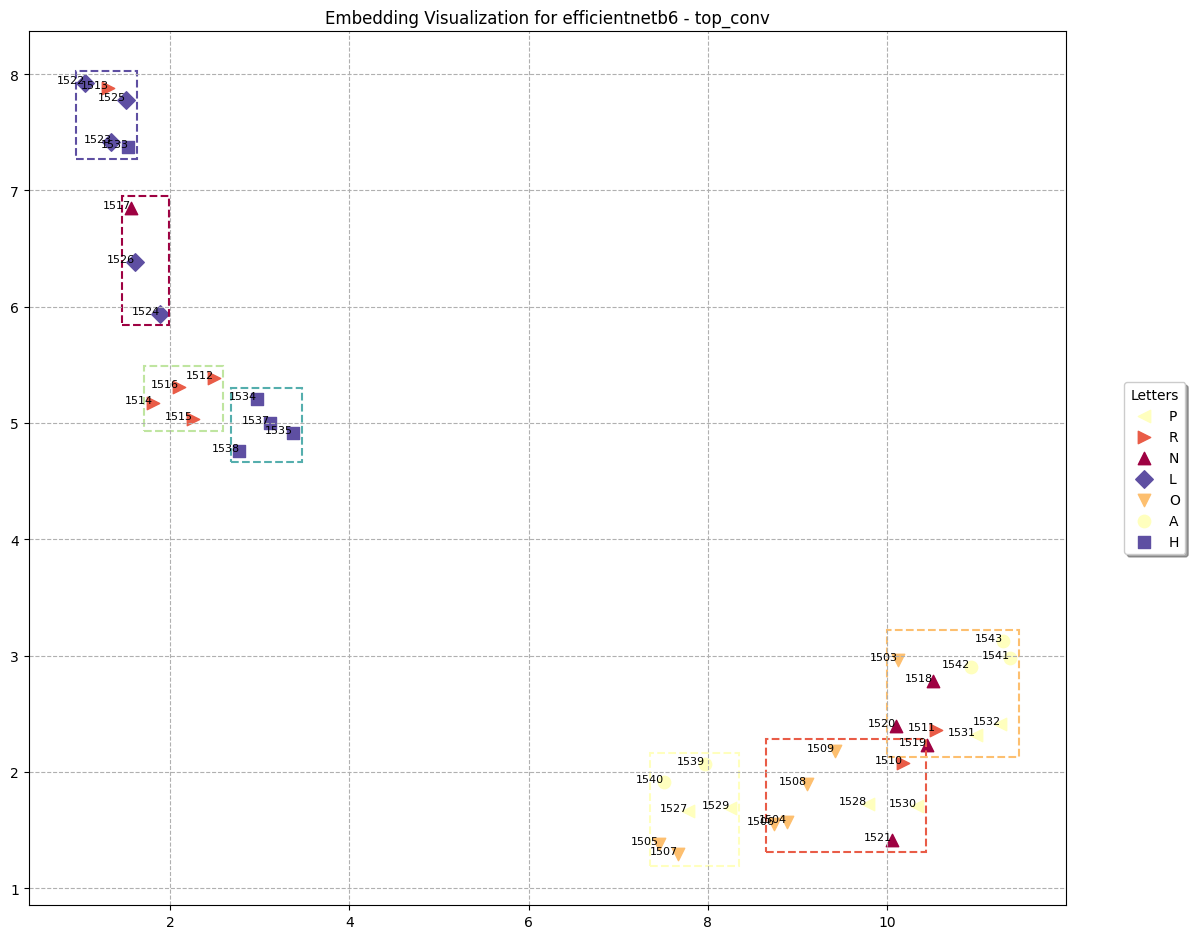

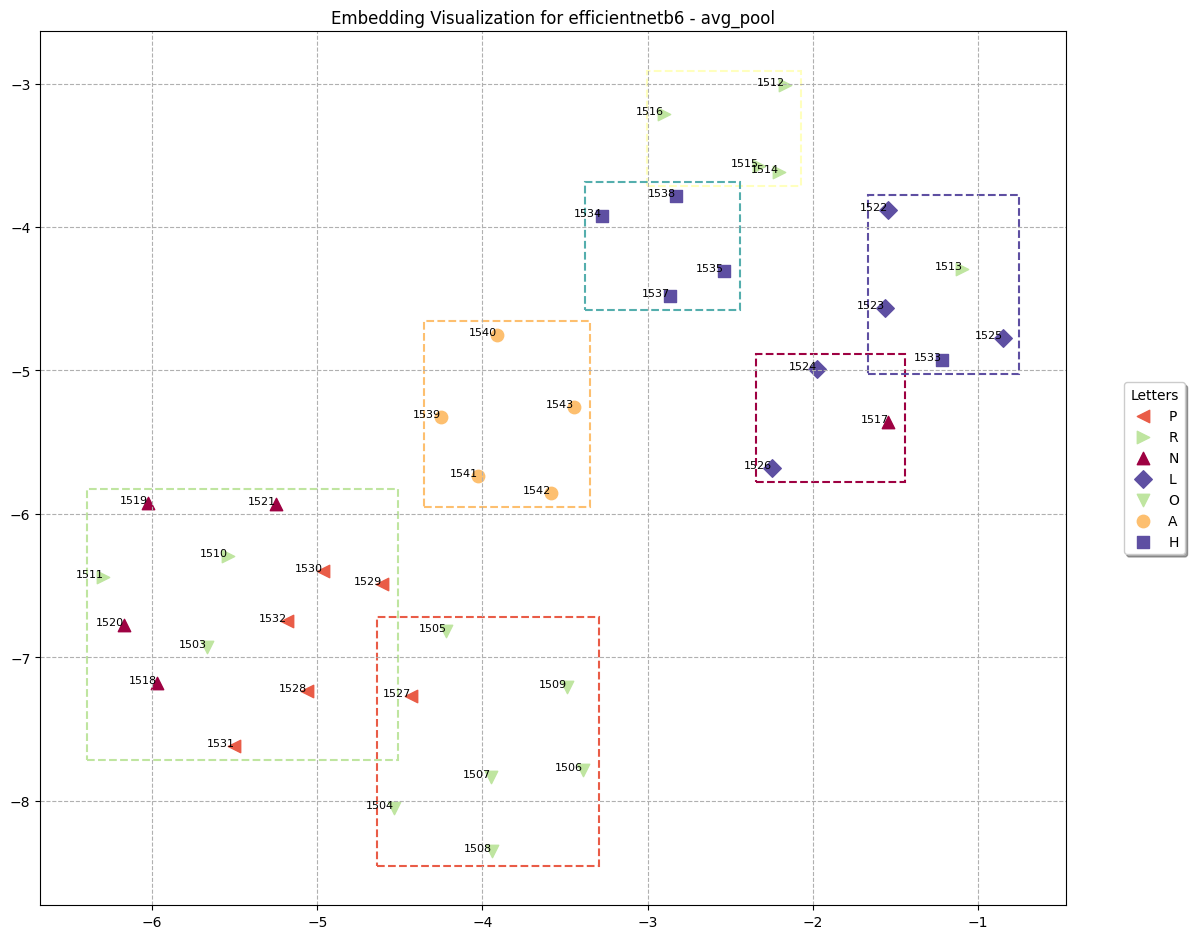

In [37]:
# Plot specific model and layer
plot_embeddings(embeddings, all_clusters, labels, img_numbers, model_to_plot="efficientnetb6")

# Grad-CAM

In [ ]:
def gradcam(img, model, input_dim, last_conv_layer_name, pred_index=None, verbose=True):
    """
    Process the image, predict using the model, generate a Grad-CAM heatmap,
    and superimpose the heatmap on the original image.

    Parameters:
    - img (PIL Image): The input image to process.
    - model (Model): The Imagenet pre-trained Keras model for prediction.
    - input_dim (tuple): Target dimensions for resizing the image (height, width).
    - last_conv_layer_name (str): Name of the last convolutional layer of the model for Grad-CAM.

    Returns:
    - preds: Predictions made by the model.
    - heatmap: Generated Grad-CAM heatmap.
    - superimposed: The superimposed image.
    """
    img_resized = img.resize(input_dim)
    img_array = np.array(img_resized)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    preds = model.predict(img_array)
    heatmap = get_gradcam_heatmap(img_array, model, input_dim, last_conv_layer_name, pred_index)
    superimposed = superimpose(img_array, heatmap)

    if verbose:
      print("Predicted:", decode_predictions(preds, top=1)[0])
      show_img(heatmap)
      show_img(superimposed)

    return heatmap, superimposed

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Predicted: [('n02099601', 'golden_retriever', 0.50699985)]


(array([[0.19677593, 0.39405107, 0.4241632 , 0.28121284, 0.20407112,
         0.22448196, 0.11374558],
        [0.5263038 , 0.75847054, 0.8178987 , 0.58606076, 0.37372765,
         0.29980895, 0.11156293],
        [0.5598664 , 0.863892  , 1.        , 0.6840162 , 0.34657317,
         0.22663844, 0.16948813],
        [0.44194016, 0.6059177 , 0.75293964, 0.5295986 , 0.23074022,
         0.18523508, 0.22501168],
        [0.28022042, 0.33648035, 0.43475083, 0.3647564 , 0.33560476,
         0.31164235, 0.24776739],
        [0.18962923, 0.17808908, 0.21242347, 0.16848627, 0.20343135,
         0.2384242 , 0.13471232],
        [0.11835561, 0.1368987 , 0.14378978, 0.11757071, 0.1082117 ,
         0.12393133, 0.05099914]], dtype=float32),
 <PIL.Image.Image image mode=RGB size=224x224>)

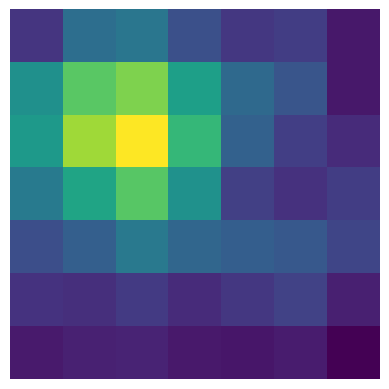

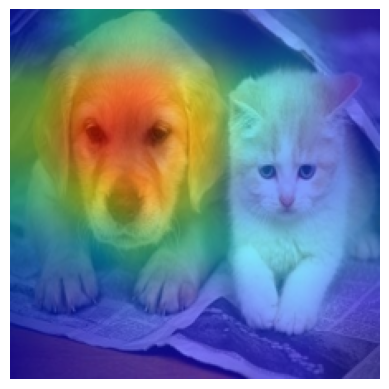

In [ ]:
# gradcam with test image
test_img = fetch_img('https://i.pinimg.com/736x/c1/7a/a2/c17aa2055d3c4e3007d0e4b432dfd3a4.jpg')
gradcam(test_img, model, input_dim, last_conv_layer_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted: [('n02099601', 'golden_retriever', 0.50699985)]


(array([[0.18698356, 0.14807266, 0.15590237, 0.2803666 , 0.3243581 ,
         0.3155625 , 0.24479045],
        [0.04800624, 0.        , 0.        , 0.11892031, 0.3429722 ,
         0.51164544, 0.339067  ],
        [0.        , 0.        , 0.        , 0.        , 0.6356273 ,
         0.79923   , 0.42108124],
        [0.09502537, 0.        , 0.        , 0.13219368, 0.7658658 ,
         1.        , 0.56694466],
        [0.18025535, 0.14885345, 0.14019433, 0.26485717, 0.40891975,
         0.5458007 , 0.4175331 ],
        [0.20556916, 0.23828654, 0.2088535 , 0.18671176, 0.23395525,
         0.32072714, 0.2606561 ],
        [0.22004436, 0.22698165, 0.19177833, 0.11022099, 0.09262454,
         0.16167417, 0.14130172]], dtype=float32),
 <PIL.Image.Image image mode=RGB size=224x224>)

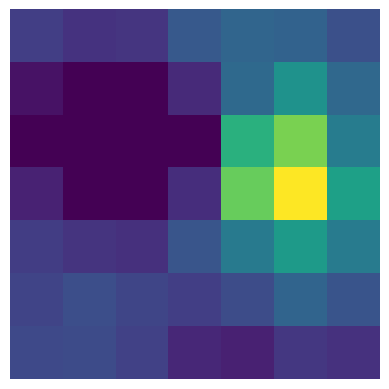

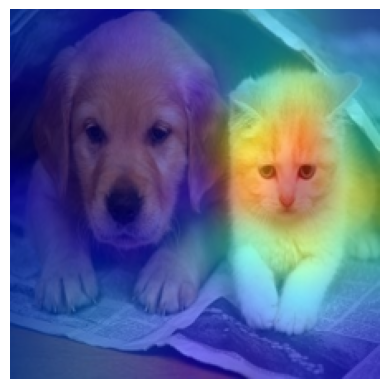

In [ ]:
# gradcam with test image for the prediction 281 - tabby cat
gradcam(test_img, model, input_dim, last_conv_layer_name, 281)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted: [('n04350905', 'suit', 0.19539803)]


(array([[0.29231632, 0.32115704, 0.43963346, 0.53784096, 0.41760182,
         0.3083314 , 0.31044993],
        [0.29083538, 0.35803184, 0.58311135, 0.80636746, 0.6262281 ,
         0.33116055, 0.2988387 ],
        [0.367842  , 0.5491656 , 0.7013693 , 1.        , 0.8082129 ,
         0.51351285, 0.31802878],
        [0.49958324, 0.9051343 , 0.9320451 , 0.8344898 , 0.7574823 ,
         0.49788964, 0.38018093],
        [0.612602  , 0.87318903, 0.8060996 , 0.6086811 , 0.6202073 ,
         0.58132654, 0.40197664],
        [0.52623844, 0.7690232 , 0.6578212 , 0.57134306, 0.6102245 ,
         0.39950064, 0.2874291 ],
        [0.5580267 , 0.76048034, 0.73844045, 0.7364698 , 0.8145043 ,
         0.506737  , 0.43754187]], dtype=float32),
 <PIL.Image.Image image mode=RGB size=224x224>)

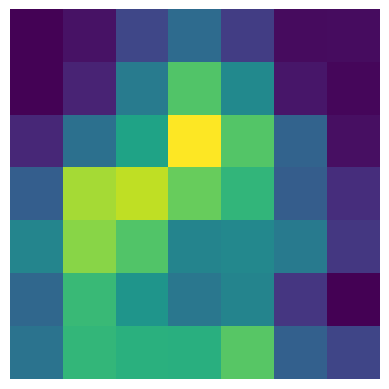

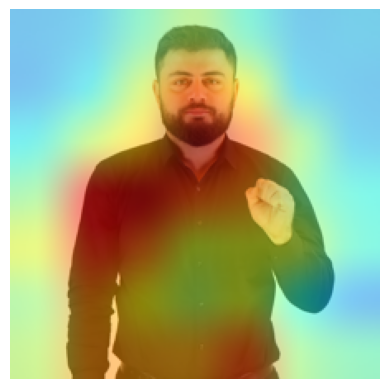

In [ ]:
gradcam(img, model, input_dim, last_conv_layer_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted: [('n04350905', 'suit', 0.19539803)]


(array([[0.29231632, 0.32115704, 0.43963346, 0.53784096, 0.41760182,
         0.3083314 , 0.31044993],
        [0.29083538, 0.35803184, 0.58311135, 0.80636746, 0.6262281 ,
         0.33116055, 0.2988387 ],
        [0.367842  , 0.5491656 , 0.7013693 , 1.        , 0.8082129 ,
         0.51351285, 0.31802878],
        [0.49958324, 0.9051343 , 0.9320451 , 0.8344898 , 0.7574823 ,
         0.49788964, 0.38018093],
        [0.612602  , 0.87318903, 0.8060996 , 0.6086811 , 0.6202073 ,
         0.58132654, 0.40197664],
        [0.52623844, 0.7690232 , 0.6578212 , 0.57134306, 0.6102245 ,
         0.39950064, 0.2874291 ],
        [0.5580267 , 0.76048034, 0.73844045, 0.7364698 , 0.8145043 ,
         0.506737  , 0.43754187]], dtype=float32),
 <PIL.Image.Image image mode=RGB size=224x224>)

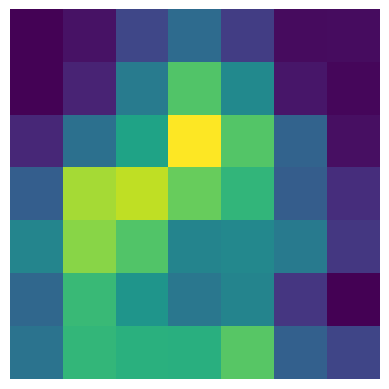

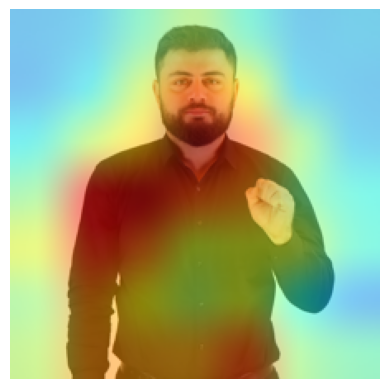

In [ ]:
# predicting for
gradcam(img, model, input_dim, last_conv_layer_name, )

In [ ]:
def plot_gradcams(img_ids, imgs, model, input_dim, last_conv_layer_name, verbose=False):
    superimposed_imgs = []

    for img_id in img_ids:
        img = imgs[img_id]
        _, superimposed = gradcam(img, model, input_dim, last_conv_layer_name, verbose=verbose)
        superimposed_imgs.append(superimposed)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, len(superimposed_imgs) + 1, 1)  # Extra space for the title
    plt.text(0.5, 0.5, model.name, fontsize=16, ha='center')  # Centered title
    plt.axis('off')

    for i, heatmap in enumerate(superimposed_imgs):
        plt.subplot(1, len(superimposed_imgs) + 1, i + 2)
        plt.imshow(heatmap)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

574710816/574710816 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
vgg19 loaded
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


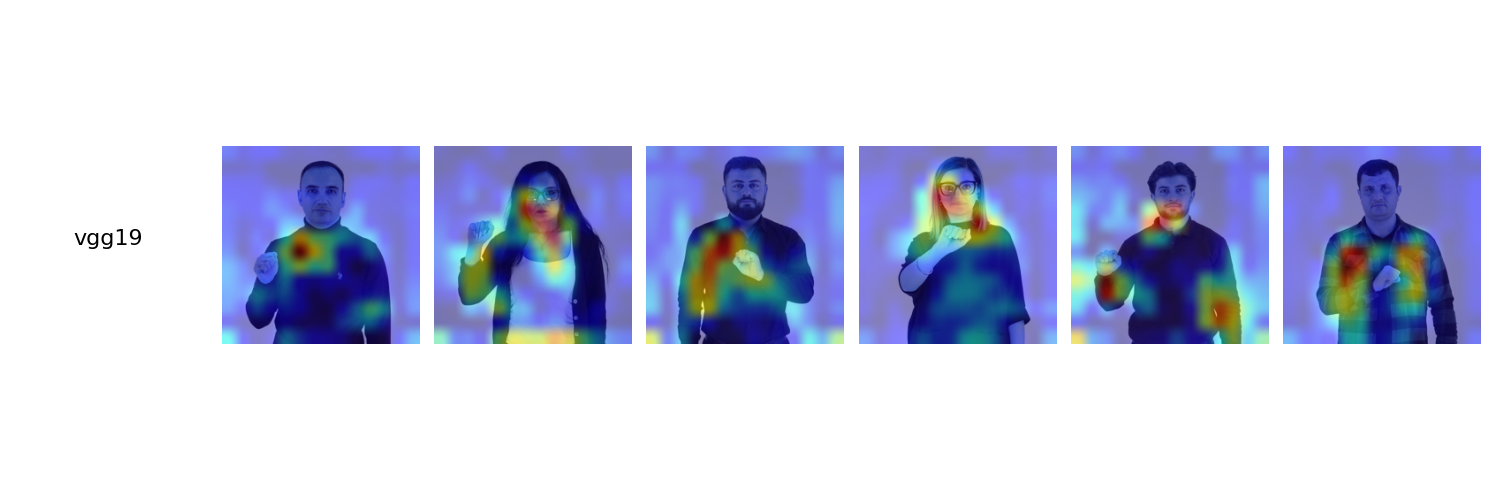

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
resnet50 loaded
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


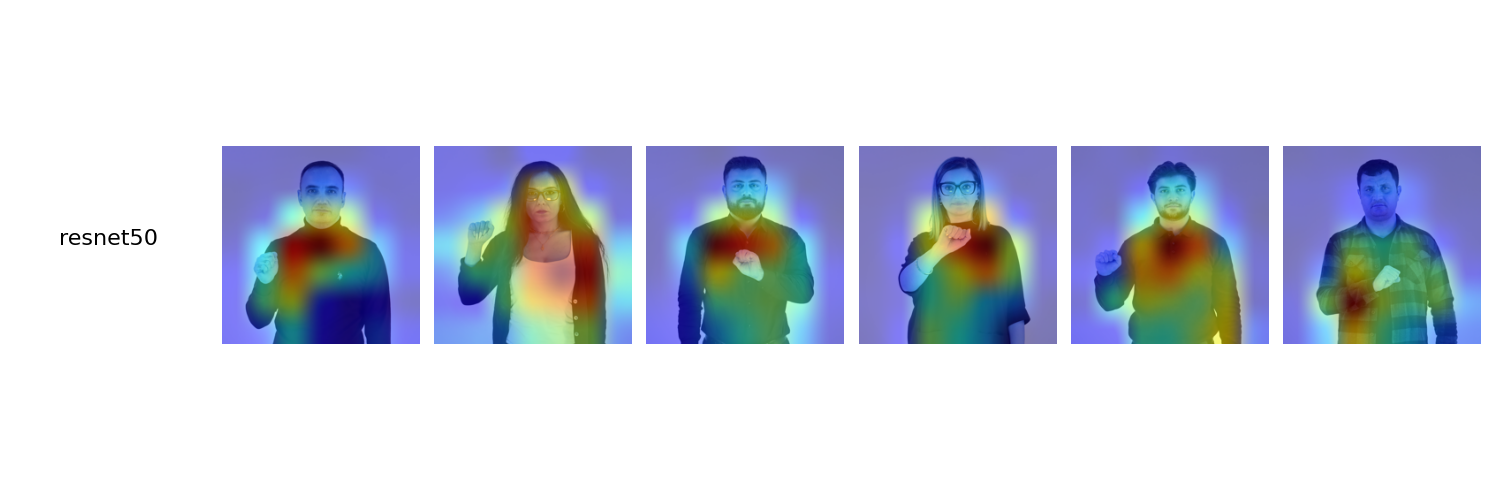

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
inception_v3 loaded
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


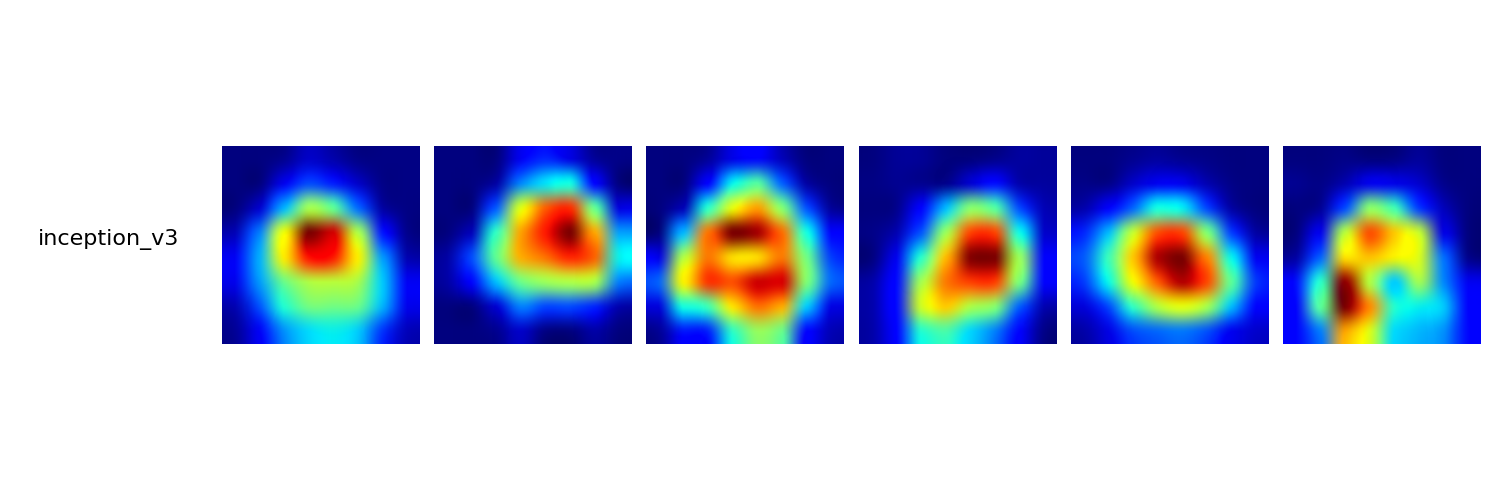

efficientnetb0 loaded
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


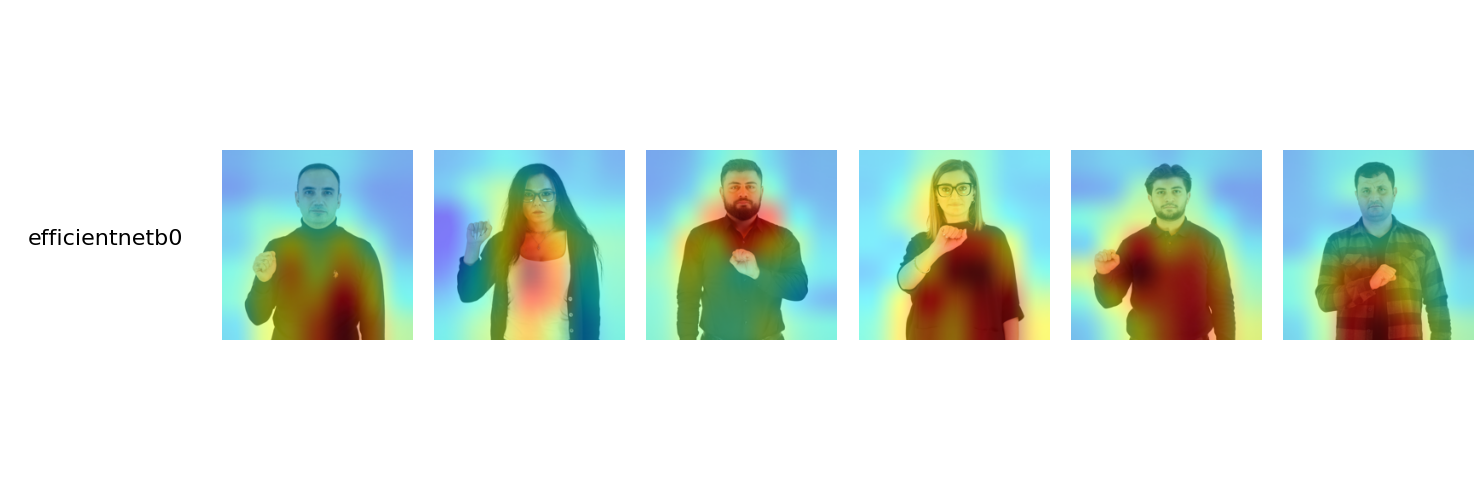

32148312/32148312 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
efficientnetb1 loaded
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


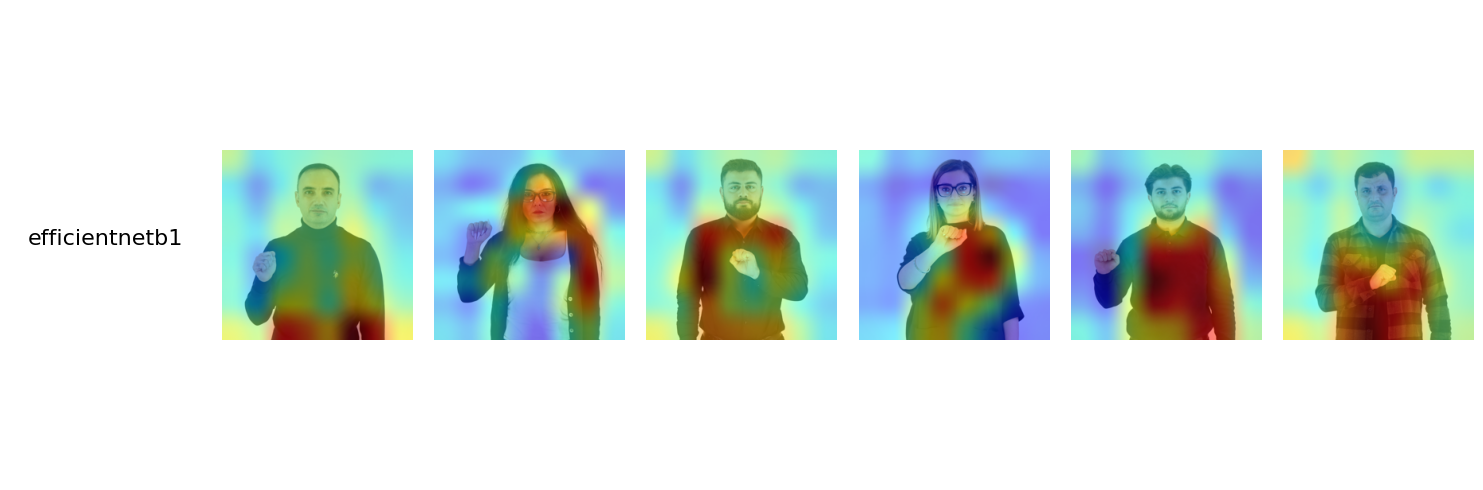

174460376/174460376 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
efficientnetb6 loaded
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


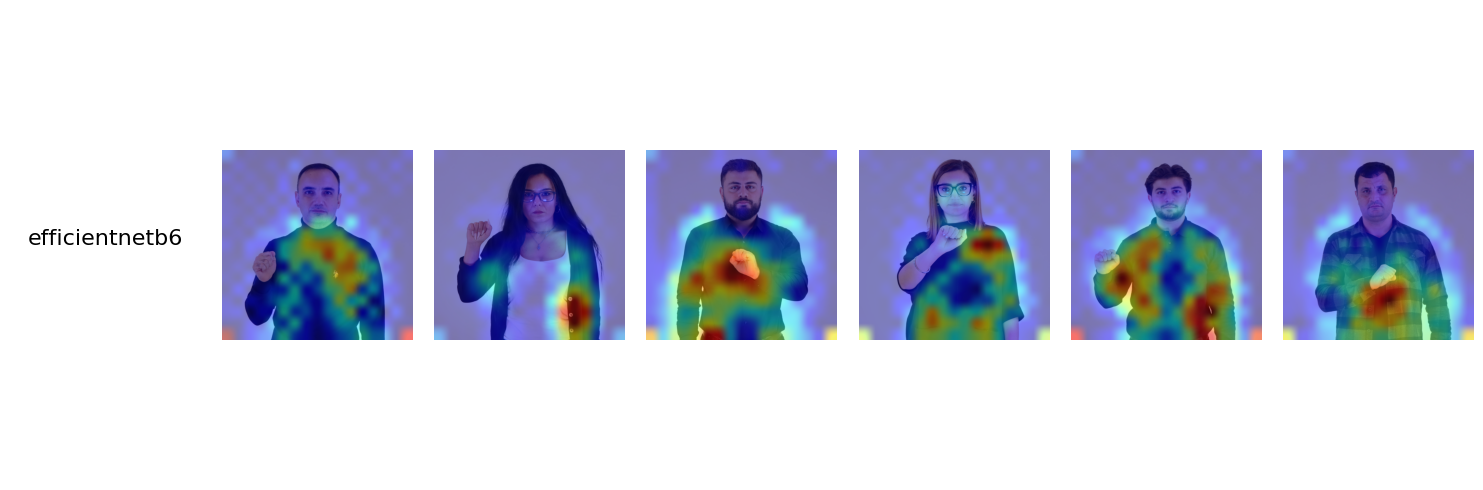

In [ ]:
# Plotting superimposed heatmaps for all models for selected images
# Inception has issue
img_ids = [0, 2, 10, 12, 17, 31]
for model_name in available_models:
  model, last_conv_layer_name, input_dim, preprocess_input, decode_predictions = load_model(model_name, include_top, debug)
  plot_gradcams(img_ids, imgs, model, input_dim, last_conv_layer_name)

In [ ]:
# !pip install mediapipe

In [ ]:
# from hand_extraction import *
# hand_imgs = detect_and_crop_hands(imgs, (600, 600))
# len(hand_imgs)

In [ ]:
# for model_name in available_models:
#   model, last_conv_layer_name, input_dim, preprocess_input, decode_predictions = load_model(model_name, include_top, debug)
#   plot_gradcams([0, 1, 2, 3], hand_imgs, model, input_dim, last_conv_layer_name, verbose=True)